# Representative flow scenarios for Lagrangian-like USV mapping

---
## Context

We want to coordinate surface drifters releases with Unmanned Surface Vehicles (USVs) monitoring in order to survey the evolution of a water mass via the mapping of surface tracers (e.g. temperature, salinity, turbidity, ...).
For these vehicles to operate autonomously, one need dedicated algorithms which have yet to be determined.
The goal of the present notebook is to list synthethic flow fields that are representative of flows over the shelf at scales less than O(10km) and may be used as reference for the development of these algorithms.

---
## Oceanographic objectives

The broad oceanographic objectives are to monitor surface fields around an ensemble of surface drifters.
Several more specific variations of such objectives may be formulated:

### "single area" monitoring

This objective consists in monitoring surface tracers in a single area defined by a central reference position $\mathbf{x}$ and a radius $R$ with a spatial resolution $r_x$ and temporal resolution $r_t$.
The reference position may be moving with time and representative of a single drifter position (*favoured choice*) or the average position of an ensemble of drifters.
The radius may be either a fixed predetermined value ($<10$km typically) either a temporally evolving value related to an ensemble of drifter positions (e.g. the minimum value such that all drifters are contained within the circle defined by $\mathbf{x}$ and $R$).
Note that lower and upper bounds are required for the latter choice (e.g. 1 km$<R<$1 km).
Typically values for the spatial and temporal resolutions may be $100$m and $1$hour for example.
See the following illustration:

<div>
<img src="s_objective0.jpeg" width="500">
</div>

### "multi area" monitoring

This objective differs from the previous one in that we want to monitor tracers around each of an ensemble of drifters with a monitoring radius $R$ and spatial resolution $r_x$ and temporal resolution $r_t$.
As drifters disperse, it may not be possible to follow all drifters and the monitoring of some drifters may have to be abandonned (because of the finite number of USV available).
Typically values for the spatial and temporal resolutions may be $100$m and $1$hour (as mentioned above).
See the following illustration:

<div>
<img src="s_objective1.jpeg" width="500">
</div>

---
## flow, overview

The horizontal surface velocity field is written $\mathbf{u} = (u, v)$ and may be, in general, a function of spatial (x,y) and temporal dimensions (t).
We sort these flows with increasing range of complexity:

- **spatially uniform, steady flow**: $\mathbf{u}_{u,s}(x,y,t) = (U, V)$ where $U$ and $V$ are constants. If representative of tidal flows, these constants may be assumed to be less than 1 m/s. If representative of low frequency (>1 days) flows, values around $0.1$m/s are more realistic.
- **elliptic and spatially uniform tidal flow**: $\mathbf{u}_t(x,y,t) = \big (U_t \cos(\omega t), V_t \sin(\omega t) \big ) $, where typically $\omega=2\pi/0.5$ day or $\omega=2\pi/1$ day and $U_t$ and $V_t$ are less than 1 m/s.
- **spatially non-uniform, steady flow**: $\mathbf{u}_{n,s}(x,y,t) = 
2 \big ( (\delta+\sigma_n)x + (\sigma_s-\zeta)y, (\sigma_s+\zeta)x + (\delta-\sigma_n)y \big ) $ where parameters describing the flow are the divergence $\delta$, the vorticity $\zeta$, and normal and shear strains $(\sigma_s, \sigma_n)$. These parameters are typically less than the local Coriolis frequency $f$ ($f=4\pi/86400 \times\sin(\phi)$ where $\phi$ is the latitude in radian).
- **random flow**: $\mathbf{u}_{r}(x,y,t)$. For such flow, one should introduce in principle temporal and spatial timescales. We can ignore spatial correlation for now but keep a temporal decorrelation. This temporal decorrelation ensures results are not sensitive on the timesteps employed in numerical simulations.

Combinations of these flows are likely: $\mathbf{u} = \mathbf{u}_{u,s} + \mathbf{u}_t + \mathbf{u}_{n,s} + \mathbf{u}_{r}$

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

day2sec = 86400.

In [2]:
from scipy.integrate import odeint
import sdeint
# `pip install sdeint` required 
# https://github.com/mattja/sdeint

def advect_drifters(ds, u, T, dt, *args):

    t = np.arange(0,T*day2sec, dt*day2sec)
    
    if isinstance(u, tuple):
        # stochastic ODE
        _one, _zero = np.eye(2), np.zeros((2,2))
        f = lambda y, t: np.block([[_zero, _one],[_zero, _one*u[0](y[0], y[1], t, *args)]]).dot(y)
        g = lambda y, t: np.block([[_zero, _zero],[_zero, _one*u[1](y[0], y[1], t, *args)]])
        solver = lambda x, y: sdeint.itoint(f, g, np.array([x, y, 0, 0]), t)[:,:2]
    else:
        # deterministic ODE
        func = lambda y, t, *args: u(y[0], y[1], t, *args)
        solver = lambda x, y: odeint(func, np.array([x, y]), t, args=args)
    
    # predent we vectorize calculations
    solver_vec = np.vectorize(solver, signature="(),()->(n,2)")
    out = solver_vec(ds.x0.values, ds.y0.values)

    return xr.Dataset(dict(x=(("label", "time"), out[...,0]), 
                           y=(("label", "time"), out[...,1]),
                          ), 
                      coords=dict(time=("time", t/day2sec), **ds.coords),
                     )

def plot_trajectories(ds, title="Trajectories (stars=start)", figsize=(5,5), axis_equal=True):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.plot(ds.isel(time=0).x.T, ds.isel(time=0).y.T, "*", color="k")
    ax.plot(ds.x.T, ds.y.T)
    ax.set_title(title)
    ax.grid()
    if axis_equal:
        ax.axis("equal")
    return fig, ax

In [3]:
# initial grid of drifters
L, dx = 1e3, 500
ds = xr.Dataset(None, coords=dict(xr=("xr", np.arange(-L/2, L/2+.1, dx)),
                                  yr=("yr", np.arange(-L/2, L/2+.1, dx)),
                                 )
               ).stack(label=["xr", "yr"])
ds["x0"] = ds.xr + 0*ds.yr
ds["y0"] = ds.xr*0. + ds.yr

# output timeline
T = 1 # in days
dt = 1/24/2 # in days

---

## spatially uniform, steady flow

In [4]:
U = .1
u_us = lambda x, y, t, u, v: (u, v)
ds_us = advect_drifters(ds, u_us, T, dt, U, U/3)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Trajectories (stars=start)'}>)

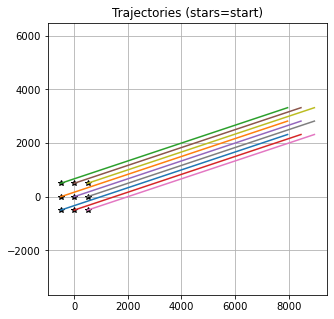

In [5]:
plot_trajectories(ds_us)

---

## spatially uniform elliptic tidal flow

In [6]:
Ut, Vt = 1., .2
omega = 2*2*np.pi/86400 # 2 cycles per day in radians per seconds
u_t = lambda x, y, t, u, v, omega: (u*np.cos(omega*t), v*np.sin(omega*t))
ds_t = advect_drifters(ds, u_t, T, dt, Ut, Vt, omega)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Trajectories (stars=start)'}>)

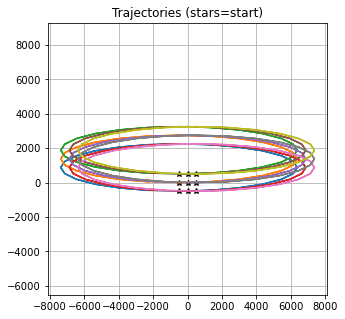

In [7]:
plot_trajectories(ds_t)

---

## spatial varying, steady flow

See appendix A of [Balwada 2021](https://doi.org/10.1175/JPO-D-21-0016.1) for an excellent reference about tracer deformation theory.


In [8]:
f = 2*2*np.pi/86400*np.sin(45*np.pi/180)

def u_ns(x, y, t, delta, zeta, sigma_n, sigma_s):
    return 2*(delta+sigma_n)*x+2*(sigma_s-zeta)*y, \
           2*(sigma_s+zeta)*x+2*(delta-sigma_n)*y

### purely divergent flow

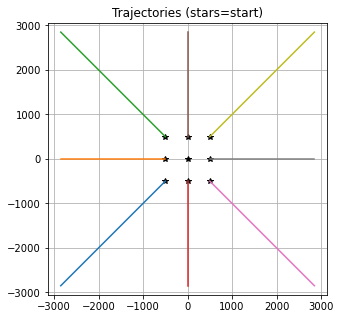

In [9]:
delta, zeta, sigma_n, sigma_s = f/10, 0., 0., 0.
ds_ns = advect_drifters(ds, u_ns, T, dt, delta, zeta, sigma_n, sigma_s)
fig, ax = plot_trajectories(ds_ns)

### purely rotational flow

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Trajectories (stars=start)'}>)

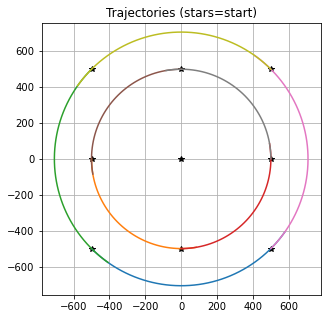

In [10]:
delta, zeta, sigma_n, sigma_s = 0., f/10, 0., 0.
ds_ns = advect_drifters(ds, u_ns, T, dt, delta, zeta, sigma_n, sigma_s)
plot_trajectories(ds_ns)

### purely sheared flow

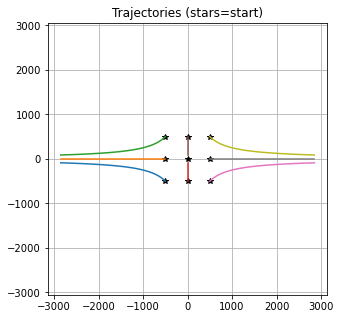

In [11]:
delta, zeta, sigma_n, sigma_s = 0., 0., f/10, 0.
ds_ns = advect_drifters(ds, u_ns, T, dt, delta, zeta, sigma_n, sigma_s)
fig, ax = plot_trajectories(ds_ns)

---
### random flow

This flow should have a velocity field that decorrelates exponentially in time.

[Sawford 1991](https://aip.scitation.org/doi/10.1063/1.857937)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Trajectories (stars=start)'}>)

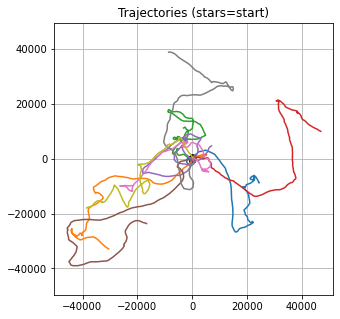

In [12]:
u_r = (lambda x, y, t, U, T: -1/T/day2sec,
       lambda x, y, t, U, T: np.sqrt(2/T/day2sec)*U,
      )

ds_r = advect_drifters(ds, u_r, T*10, dt, .1, 1.)
plot_trajectories(ds_r)

---
### combinations

We'll combine a steady uniform and non-uniform flow, tidal flows: $\mathbf{u} = \mathbf{u}_{u,s} + \mathbf{u}_t + \mathbf{u}_{n,s}$
We ignore random contribution for now for purely technical reasons.

Any contribution of the flow below may be turned off and still be representative of a realistic flow over the shelf

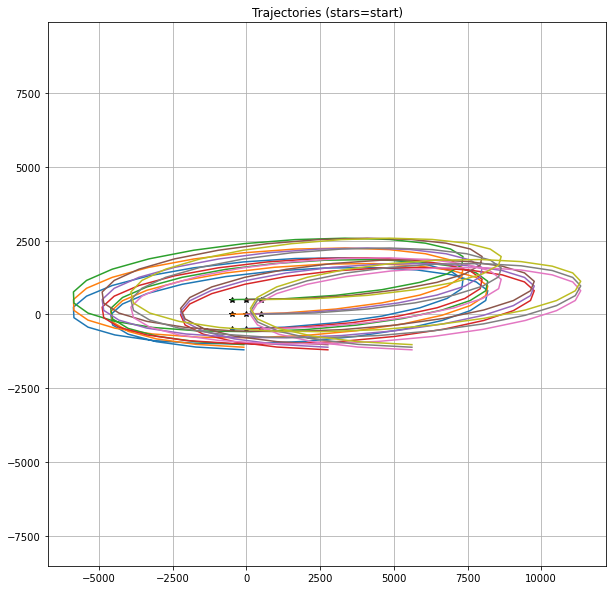

In [13]:

# spatially uniform steady flow
Us, Vs = 0., 0.

# tidal flow
Ut, Vt = 1., .2
omega = 2*2*np.pi/86400 # 2 cycles per day in radians per seconds

# purely sheared flow
delta, zeta, sigma_n, sigma_s = 0., 0., f/10., 0.

def u_cb(x, y, t, 
         Us, Vs,
         Ut, Vt, omega, 
         delta, zeta, sigma_n, sigma_s,
        ):
    _us = u_us(x,y,t, Us, Vs)
    _t = u_t(x,y,t, Ut, Vt, omega)
    _ns = u_ns(x,y,t,delta, zeta, sigma_n, sigma_s)
    return _us[0]+_t[0]+_ns[0], _us[1]+_t[1]+_ns[1]

# centered initial conditions
ds["x0"] = ds.xr + 0*ds.yr
ds["y0"] = ds.xr*0. + ds.yr
    
ds_combined = advect_drifters(ds, u_cb, T, dt, Us, Vs, Ut, Vt, omega, delta, zeta, sigma_n, sigma_s)
fig, ax = plot_trajectories(ds_combined, figsize=(10,10))

One may slightly modify drifter position and notice the sensitivity with respect to initial position

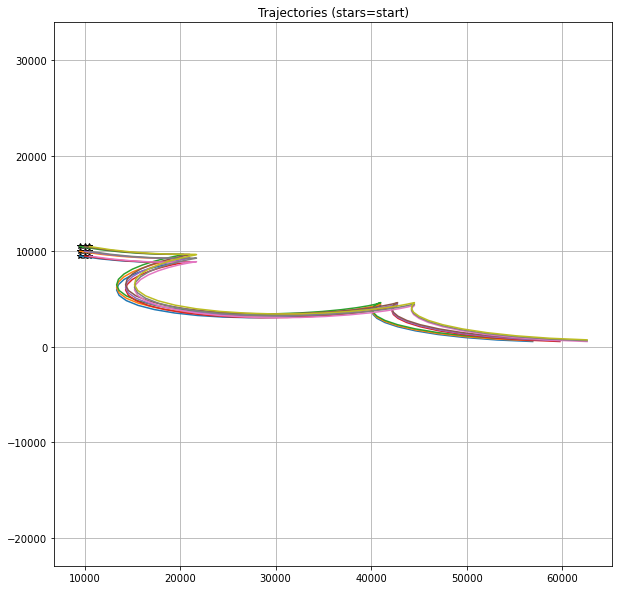

In [14]:
ds["x0"] = ds.xr + 0*ds.yr + 10e3
ds["y0"] = ds.xr*0. + ds.yr + 10e3

ds_combined = advect_drifters(ds, u_cb, T, dt, Us, Vs, Ut, Vt, omega, delta, zeta, sigma_n, sigma_s)
fig, ax = plot_trajectories(ds_combined, figsize=(10,10), axis_equal=True)